Actions each agent have to decide between: Leave or Stay 

In [336]:
import numpy as np

class Agent: 
    def __init__(self, music_taste = 1, strategy = 1, nr_concerts = 3, festival_duration=9):
        self.music_taste = music_taste
        self.position_utility = 0
        self.accumulated_position_utility = 0
        self.waiting_utility_history = np.zeros(festival_duration)
        self.strategy = strategy
        self.position_utility_history = np.zeros(festival_duration)
        self.concert_history = np.ones(festival_duration)*(nr_concerts-1)
        self.concert_history[0] = 0 #start at first concert 


    
class Concert:
    def __init__(self, len_rows = 1, music_type = 1, capacity = 5, duration = 2, nr_of_agents = 10):
        self.len_rows = len_rows
        self.music_type = music_type
        self.nr_agents = 0
        self.nr_waiting_agents = 0
        self.capacity = capacity
        self.nr_rows = np.ceil(capacity/len_rows)
        self.duration = duration #timesteps
        self.agents = np.zeros(nr_of_agents)

    def add_agent(self):
        self.nr_agents += 1

def get_placement_utility(concert):
    placement_factor = 5
    #continuing using sigmoid
    #fullness = concert.nr_agents / concert.capacity
    #sigmoid_x = 1 - fullness
    #k = 10 #steepness of sigomid
    #center = 0.5 #[0,1] with 0.1 happy crowd and 0.9 happy front row
    #utility = placement_factor * 1 / ( 1 + np.exp(-k*(sigmoid_x- center)))

    #stepwise by which row the agent is in, sensitive to concert row length
    dist_from_stage = np.floor((concert.nr_agents) / concert.len_rows)
    utility = placement_factor * (concert.nr_rows - dist_from_stage) / concert.nr_rows
    return utility

def get_time_at_concert_utility(agent):
    utility += agent

def get_waiting_utility():
    waiting_factor = 1
    utility = -1 * waiting_factor
    return utility

Strategies: Sart with defining strategies that do not depend on any history. Deterministic depending on which timestep it likes to leave

In [337]:
def get_action(agent, timestep, max_time):
    # Stay at the consert
    if (agent.strategy == 1):
        if (timestep == max_time - 1):
            action = 'leave'
        else:
            action = 'stay'
        
    # Leave to the next concert as early as possible
    if (agent.strategy == 2):
        if (timestep == 0):
            action = 'leave'
        else:
            print("Leaving agent stayed")

    # Gows in the middle of the concert
    if (agent.strategy == 3):
        if (timestep == 3):
            action = 'leave'
        else:
            action = 'stay'

    return action


Inintialize variables

In [ ]:
nr_of_agents = 100
nr_concerts = 10
concert_duration = 5

In [ ]:

festival_duration = nr_concerts*concert_duration
agents = []
concerts = []

for _ in range (nr_of_agents):
    agents.append(Agent(music_taste=np.random.randint(1,4), strategy=np.random.randint(1,4), nr_concerts=nr_concerts, festival_duration = festival_duration))

for _ in range(nr_concerts):
    concerts.append(Concert(music_type=np.random.randint(1,3), capacity = nr_of_agents, duration = concert_duration, nr_of_agents = nr_of_agents))

#Add all agents to the starting concerts in a random order
shuffled_indices = np.random.permutation(nr_of_agents)
for i in range (nr_of_agents):
    idx = shuffled_indices[i]
    position_utility = 0 #Starting utility is zero
    concerts[0].add_agent() 
    concerts[0].agents[idx] = 1
    agents[idx].position_utility = position_utility
    agents[idx].accumulated_position_utility = position_utility
    concerts[0].add_agent() 


#TODO All agents leaving during the same timestep must get the same utility

In [339]:
def move_agent_to_next_concert(agent, idx, current_concert, next_concert, timestep, global_time):
    timesteps_left = current_concert.duration-timestep
    # Fill up agent's waiting utilities until the next concert
    idx_counter = 0
    for k in range(0,timesteps_left-1):
        agent.waiting_utility_history[global_time+k] = get_waiting_utility() + agent.waiting_utility_history[global_time+k -1]
        agent.position_utility_history[global_time+k] = agent.position_utility_history[global_time-1] 
        idx_counter += 1
    agent.waiting_utility_history[global_time + timesteps_left-1] = agent.waiting_utility_history[global_time+idx_counter-1]
    
    # Find position utility at next concert, add to history
    position_utility = get_placement_utility(next_concert)
    agent.position_utility = position_utility
    agent.position_utility_history[global_time + timesteps_left-1] = position_utility + \
    agent.position_utility_history[global_time-1]
    
    next_concert.add_agent() 
    next_concert.agents[idx] = 1

In [ ]:
global_time = 0
for concert_idx in range(0,len(concerts)-1):
    current_concert = concerts[concert_idx]
    next_concert = concerts[concert_idx + 1]
    #next_next_concert = concerts[ i + 2]

    for timestep in range(0,current_concert.duration):
        # Update time
        global_time += 1
        shuffled_indices = np.random.permutation(nr_of_agents)
        for j in range (nr_of_agents):
            idx = shuffled_indices[j]
            
            if (current_concert.agents[idx] == 0):  
                # Not attending the concert 
                continue
               
            action = get_action(agents[idx],timestep, current_concert.duration)
            
            if (action == 'leave'):
                # Leave current concert
                current_concert.agents[idx] = 0
                
                for k in range(0,current_concert.duration-timestep):
                    #Update agent's concert history
                    agents[idx].concert_history[global_time + k] = concert_idx + 1

                # Set agent up at the next concert
                move_agent_to_next_concert(agents[idx], idx, current_concert, next_concert, timestep, global_time)
                
            else: #they stay at the concert one more time step
                # Improve position utility
                agents[idx].position_utility_history[global_time] = agents[idx].position_utility_history[global_time-1] + \
                agents[idx].position_utility
                # Leave waiting utility unchanged
                agents[idx].waiting_utility_history[global_time] = agents[idx].waiting_utility_history[global_time - 1]
                
                #Update agent's concert history
                agents[idx].concert_history[global_time] = concert_idx 
                
    # Let all agents stay at the last concert
    if (concert_idx == nr_concerts-2):
        for agent in agents:
            for k in range(0,next_concert.duration):
                agent.position_utility_history[global_time+k] = agent.position_utility_history[global_time+k-1] + \
                agent.position_utility
                agent.waiting_utility_history[global_time+k] = agent.waiting_utility_history[global_time - 1]
            

In [341]:
# idx = 1
# print("Strategy: ", agents[idx].strategy)
# print("Total time steps: ", len(agents[idx].concert_history), ", Concert duration: ", concert_duration, ", Nr of concerts: ", len(concerts))
# print("Arena at each timestp: ", agents[idx].concert_history)
# print("Waiting utility history: ", agents[idx].waiting_utility_history)
# print("Position utility history: ", agents[idx].position_utility_history)

Some basic plots of how utility change with time

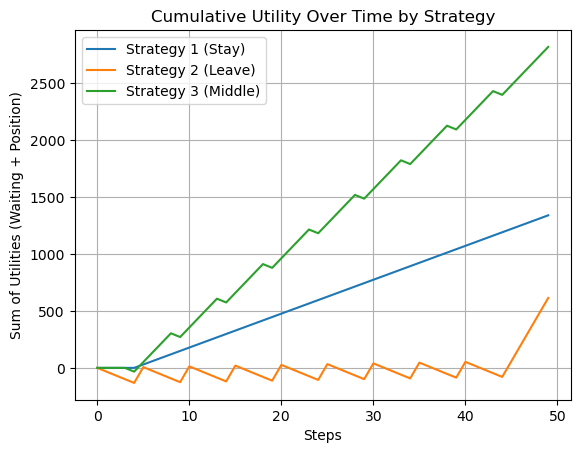

In [342]:
import matplotlib.pyplot as plt

agents_strategy_stay = [agent for agent in agents if agent.strategy == 1]
agents_strategy_leave = [agent for agent in agents if agent.strategy == 2]
agents_strategy_middle = [agent for agent in agents if agent.strategy == 3]

timesteps = np.arange(festival_duration)
sum_utility_stay = np.zeros(festival_duration)
sum_utility_leave = np.zeros(festival_duration)
sum_utility_middle = np.zeros(festival_duration)

# Sum utilities for strategy 1 (stay)
for agent in agents_strategy_stay:
    sum_utility_stay += agent.waiting_utility_history + agent.position_utility_history

# Sum utilities for strategy 2 (leave)
for agent in agents_strategy_leave:
    sum_utility_leave += agent.waiting_utility_history + agent.position_utility_history

# Sum startegy 3 (go in the middle)
for agent in agents_strategy_middle:
    sum_utility_middle += agent.waiting_utility_history + agent.position_utility_history

plt.plot(timesteps, sum_utility_stay, label="Strategy 1 (Stay)")
plt.plot(timesteps, sum_utility_leave, label="Strategy 2 (Leave)")
plt.plot(timesteps, sum_utility_middle, label="Strategy 3 (Middle)")
plt.xlabel("Steps")
plt.ylabel("Sum of Utilities (Waiting + Position)")
plt.title("Cumulative Utility Over Time by Strategy")
plt.legend()
plt.grid(True)
plt.show()

In [343]:
 # elif (action == 'skip'):
            #     agents[idx].position_history.append(agents[idx].accumulated_position_utility) #rätt tillfälle?
            #     agents[idx].waiting_utility_history += get_waiting_utility(next_next_concert.duration)
            #     position_utility = get_placement_utility(next_next_concert)
            #     next_next_concert.add_agent() 
            #     next_next_concert.agents[idx] = 1
            #     agents[idx].position_utility = position_utility
            #     agents[idx].accumulated_position_utility = position_utility
            #     current_concert.agents[idx] = 0
            #     #Update agent's concert history
            #     agents[idx].concert_history.append(i+2) #does not work
                

How did the simulation go?

In [344]:
from graphs import BarGraph
A = np.zeros([nr_concerts, int(nr_concerts*concerts[0].duration)])

agent_concert = []

# Make dataset
for agent in agents:
    agent_concert.append(agent.concert_history)

for agent in agent_concert:
    t = 0
    for i in agent:
        A[i, t] += 1
        t += 1

graph = BarGraph(A)
graph.plot_data(5)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
sorted_agents = sorted(agents, key=lambda agent: sum(agent.position_history) + agent.waiting_utility, reverse=True)
for i in range (nr_of_agents):
    print("Utility: ", sum(sorted_agents[i].position_history) + sorted_agents[i].waiting_utility, ", Strategy: ", sorted_agents[i].strategy)